# Support Vector Machine Neighborhood Classifier

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split
import pandas as pd
import pickle
from time import time
from skimage import morphology

In [2]:
# %load ../../../data_preprocessing/functions.py
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

# A function to plot a matrix
def plot_image(data, colorspace='binary'):
    fig = plt.figure(figsize=(10,10)) 
    ax = fig.add_subplot(111)
    ax.imshow(data, cmap=colorspace)
    
    
def normalize_array(array):
    array_min = array.min(axis=(0, 1), keepdims=True)
    array_max = array.max(axis=(0, 1), keepdims=True)
    normalized_array = (array - array_min)/(array_max - array_min)
    
    return normalized_array

def normalize_with_preset(array, max_value, min_value):
    normalized_array = (array - min_value)/(max_value - min_value)
    
    return normalized_array


def recreate_image(labels, w, h):
    """Recreate the (compressed) image from the code book & labels"""
    image = np.zeros((w, h))
    label_idx = 0
    for i in range(w):
        for j in range(h):
            image[i][j] = labels[label_idx]
            label_idx += 1
    return image

def overlay_images(image1, image2, colorspace1='binary', colorspace2='magma', transparency=0.5):
    plt.imshow(image1, cmap=colorspace1, interpolation='nearest')
    plt.imshow(image2, cmap=colorspace2, alpha=transparency, interpolation='bilinear')
    plt.show()
    
def flatten_normalize_neighbors(training_set, global_max=233, global_min=69):
    flattened_neighbors = []
    neighbors = training_set['neighbors']

    for i in range(len(neighbors)):
        numpy_array = np.array(neighbors[i]).reshape(-1, 1)
        normalized_neighbors = normalize_with_preset(numpy_array, global_max, global_min)
        flattened_neighbors.append(normalized_neighbors)
    
    return np.array(flattened_neighbors).reshape((len(flattened_neighbors), -1))

def extract_values_from_training_data_locations(training_data, image_channel):
    data_values = []
    
    for row in training_data:
        data_values.append(np.array([(image_channel[row[0], row[1]]), row[2]]))
        
    data_values = np.array(data_values)
    
    return data_values

def extract_neighborhood_values_from_training_data_locations(training_data, image_channel):
    data_values = []
    
    for row in training_data:
        data_values.append(np.array([(image_channel[row[0], row[1]]), row[2]]))
        
    data_values = np.array(data_values)
    
    return data_values

def flatten_neighbors(neighbors):
    data_values = []
    
    for neighbor in neighbors:
        #data_values.append(neighbor[0].reshape(-1, 1))
        data_values.append(neighbor[0].reshape(-1, 1))
    
    data_values = np.array(data_values)
    
    return data_values

def extract_labels_from_set(dataset):
    labels = []
    for neighbor in training_set:
        labels.append(neighbor[1])

    return np.array(labels).flatten()

## Open up the data files

In [5]:
training_set = np.load("../../../supervised_learning/notebooks/data/june10/neighborhood_training_data_with_labels.npy")

In [6]:
training_set.shape

(670, 2)

In [7]:
training_set[0][0].reshape(-1, 1).shape

(100, 1)

In [8]:
# training_set[0][0].shape
flattened_neighbors = []
for block in training_set:
    #flat_block = block[0].reshape(-1, 1)
    flat_block = block[0].reshape(-1, 1)
    flattened_neighbors.append(flat_block)

flattened_neighbors = np.array(flattened_neighbors).reshape(-1, 100)

## Flatten each pixel neighborhood

In [9]:
# flattened_neighbors = flatten_neighbors(training_set).reshape(training_set.shape[0], -1)
flattened_neighbors.shape

(670, 100)

In [10]:
labels = extract_labels_from_set(training_set)

## Shuffle data and create splits

In [11]:
values_train, values_test, labels_train, labels_test = train_test_split(flattened_neighbors, labels, test_size=0.15, random_state=0)

In [12]:
values_train.shape

(569, 100)

## Do some PCA to reduce dimensionality and find principal descriptor of lithology

## Initialize the SVM algorithm

In [11]:
classifier = svm.SVC()

In [12]:
classifier.fit(values_train, labels_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

## Execute a classification of unkown values

In [13]:
rgb_image = np.load('../../../data_preprocessing/data_preprocessing/numpy_data/indios_b/normalized_filtered_rgb.npy')
hsv_image = np.load('../../../data_preprocessing/data_preprocessing/numpy_data/indios_b/normalized_filtered_hsv.npy')

In [14]:
rgb_image_subset = rgb_image[0:6000, 0:6000, :]
hsv_subset = hsv_image[0:6000, 0:6000, :]

In [15]:
w, h, c = tuple(rgb_image_subset.shape)

In [16]:
full_ortho = np.dstack((rgb_image_subset, hsv_subset))
# rgb_flattened_subset = rgb_image_subset

In [17]:
# ortho_reshaped = full_ortho.reshape(w*h, -1, c)
reshaped_ortho = full_ortho.reshape(w*h, -1, c)

In [18]:
full_ortho.shape

(6000, 6000, 6)

In [19]:
# blabels = classifier.predict(reshaped_ortho.reshape(-1, c))

In [20]:
# classifier.predict(ortho_reshaped[0][0])

In [21]:
full_ortho.shape

(6000, 6000, 6)

In [22]:
test = rgb_image[:, :, 0][2000-5:2000+5, 2000-5:2000+5].reshape(1, -1)

In [23]:
subset = rgb_image[:, :, 0]

In [24]:
t0 = time()
prediction_map = np.zeros((w, h))
for i in range(5, w-5):
    for j in range(5, h-5):
        test = subset[i-5:i+5, j-5:j+5].reshape(1, -1)
        prediction = classifier.predict(test)
        prediction_map[i][j] = prediction[0]
print("done in %0.3fs." % (time() - t0))

done in 31526.608s.


In [31]:
# Save the classifier
from sklearn.externals import joblib
joblib.dump(classifier, './nighborhood_model.pkl') 

['./nighborhood_model.pkl']

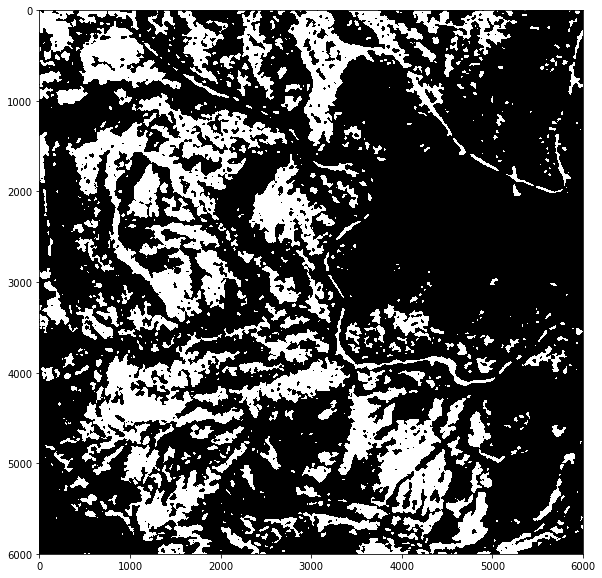

In [28]:
plot_image(prediction_map, colorspace='binary')

In [30]:
# Store the prediction map
np.save("./results/svm/prediction_map.npy", prediction_map)

### Some experiments for the thesis image

In [3]:
pred_map = np.load("./results/svm/prediction_map.npy")

In [17]:
out = morphology.binary_opening(pred_map)

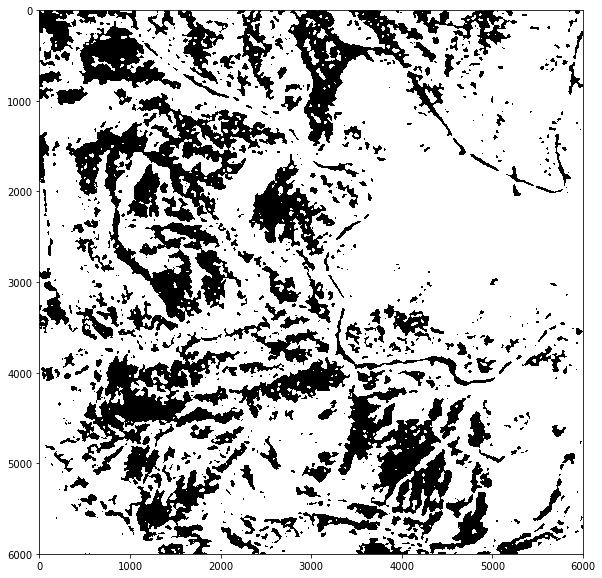

In [23]:
plot_image(out, 'binary')

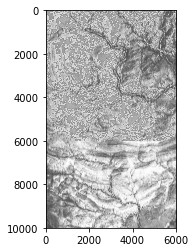

In [32]:
overlay_images(prediction_map, subset, colorspace1='binary', colorspace2='gray', transparency=0.7)

In [33]:
prediction_map.shape

(6000, 6000)

In [161]:
np.save('neighborhood_classified_svm.npy', prediction_map)

In [34]:
import scipy.misc
scipy.misc.imsave('./neighborhood_classified_svm.jpg', prediction_map)

In [35]:
scipy.misc.imsave('./block.jpg', rgb_image_subset)

# Generate classification report

In [1]:
from sklearn.metrics import classification_report

### Load up the trained algorithm

In [20]:
from sklearn.externals import joblib
clf = joblib.load('./nighborhood_model.pkl') 

In [25]:
predicted_test_labels = clf.predict(values_test)

In [26]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [29]:
target_names = ["Bluff Mesa Formation", "Lower Yucca"]

In [31]:
print(classification_report(labels_test, predicted_test_labels, target_names=target_names))
# print(confusion_matrix(labels_test, predicted_test_labels, labels=range(2)))

                      precision    recall  f1-score   support

Bluff Mesa Formation       0.77      0.79      0.78        62
         Lower Yucca       0.65      0.62      0.63        39

         avg / total       0.72      0.72      0.72       101

